In [ ]:
'''
 * Copyright (c) 2005 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Multiclass Logistic Regression: Maximum Likelihood and IRLS

### Softmax Function for Multiclass Logistic Regression

For multiclass classification, the posterior probabilities are given by the **softmax** transformation:

$$
p(C_k | \phi) = y_k(\phi) = \frac{\exp(a_k)}{\sum_{j} \exp(a_j)}
$$

where the activations $a_k$ are:

$$
a_k = \mathbf{w}_k^T \phi.
$$

### Derivatives of Softmax

To optimize the parameters $\{\mathbf{w}_k\}$ using maximum likelihood, we need the derivatives of $y_k$ with respect to all activations $a_j$:

$$
\frac{\partial y_k}{\partial a_j} = y_k (\mathbb{I}_{kj} - y_j),
$$

where $\mathbb{I}_{kj}$ is the Kronecker delta (1 if $k=j$, otherwise 0).

## Likelihood and Cross-Entropy Error

Using a 1-of-K coding scheme, where the target vector $\mathbf{t}_n$ is binary with all zeros except for the index corresponding to the true class, the likelihood function is:

$$
p(T | \mathbf{w}_1, \dots, \mathbf{w}_K) = \prod_{n=1}^N \prod_{k=1}^K y_{nk}^{t_{nk}},
$$

where $y_{nk} = y_k(\phi_n)$ and $T$ is the target matrix with elements $t_{nk}$.

Taking the negative log-likelihood gives the **cross-entropy error function**:

$$
E(\mathbf{w}_1, \dots, \mathbf{w}_K) = - \sum_{n=1}^N \sum_{k=1}^K t_{nk} \ln y_{nk}.
$$

## Gradient of the Cross-Entropy Error

The gradient of the error function with respect to \(\mathbf{w}_j\) is:

$$
\nabla_{\mathbf{w}_j} E(\mathbf{w}_1, \dots, \mathbf{w}_K) = \sum_{n=1}^N (y_{nj} - t_{nj}) \phi_n.
$$

This form resembles the gradients for both the logistic regression model and the sum-of-squares error function.

## Hessian Matrix and IRLS Algorithm

The Hessian matrix for the multiclass logistic regression comprises blocks of size $M \times M$, where block $j, k$ is given by:

$$
\nabla_{\mathbf{w}_k} \nabla_{\mathbf{w}_j} E(\mathbf{w}_1, \dots, \mathbf{w}_K) = - \sum_{n=1}^N y_{nk} (\mathbb{I}_{kj} - y_{nj}) \phi_n \phi_n^T.
$$

The error function is **convex** since the Hessian is positive definite, guaranteeing a unique minimum. 

## Iteratively Reweighted Least Squares (IRLS)

The Newton-Raphson update for multiclass logistic regression leads to an IRLS algorithm for solving the optimization problem:

1. **Compute Gradient**:
   $$
   \nabla_{\mathbf{w}_j} E = \Phi^T (\mathbf{y}_j - \mathbf{t}_j)
   $$

2. **Compute Hessian**:
   $$
   H = \Phi^T R \Phi
   $$

   where $R$ is a block diagonal matrix dependent on $y_{nk}(1 - y_{nk})$.

3. **Update Weights**:
   $$
   \mathbf{w}^{\text{new}} = \mathbf{w}^{\text{old}} - H^{-1} \nabla E.
   $$

This batch algorithm iteratively updates weights to minimize the cross-entropy error until convergence.

---


TypeError: 'float' object is not iterable

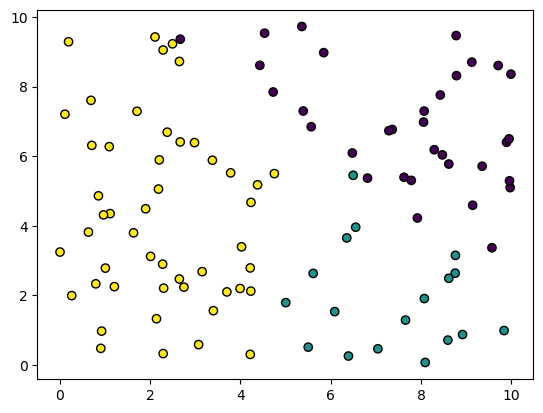

In [4]:
import random
import math
import matplotlib.pyplot as plt

# Generate identity matrix
def identity(size):
    return [[1 if i == j else 0 for j in range(size)] for i in range(size)]

# Matrix multiplication helper
def mat_mult(A, B):
    assert len(A[0]) == len(B), "Number of columns in A must match number of rows in B"
    return [[sum(A[i][k] * B[k][j] for k in range(len(B))) for j in range(len(B[0]))] for i in range(len(A))]

# Transpose of a matrix
def transpose(A):
    return [[A[j][i] for j in range(len(A))] for i in range(len(A[0]))]

# Regularized Gaussian elimination to find inverse of a matrix
def inverse_matrix_general(A, reg=1e-6):
    size = len(A)
    I = identity(size)
    augmented = [A[i] + I[i] for i in range(size)]

    for i in range(size):
        augmented[i][i] += reg  # Regularization
        diag_val = augmented[i][i]
        if abs(diag_val) < 1e-10:
            raise ValueError("Matrix is singular or ill-conditioned.")
        for j in range(2 * size):
            augmented[i][j] /= diag_val

        for k in range(size):
            if k != i:
                factor = augmented[k][i]
                for j in range(2 * size):
                    augmented[k][j] -= factor * augmented[i][j]

    return [row[size:] for row in augmented]

# Softmax function
def softmax(activations):
    max_val = max(activations)
    exps = [math.exp(a - max_val) for a in activations]
    sum_exps = sum(exps)
    return [exp / sum_exps for exp in exps]

# Generate synthetic data
def generate_data(n_samples):
    random.seed(42)
    X = [[random.uniform(0, 10), random.uniform(0, 10)] for _ in range(n_samples)]
    T = [[0, 0, 0] for _ in range(n_samples)]
    
    for i in range(n_samples):
        if X[i][0] + X[i][1] > 12:
            T[i][0] = 1
        elif X[i][0] > 5:
            T[i][1] = 1
        else:
            T[i][2] = 1
    return X, T

# IRLS for multiclass logistic regression
def irls_multiclass(X, T, num_classes, max_iter=100, tol=1e-5):
    n_samples, n_features = len(X), len(X[0])
    weights = [[0] * n_features for _ in range(num_classes)]

    for iteration in range(max_iter):
        activations = [[sum(weights[k][j] * X[i][j] for j in range(n_features)) for k in range(num_classes)] for i in range(n_samples)]
        y = [softmax(a) for a in activations]

        grad = [[sum((y[i][j] - T[i][j]) * X[i][k] for i in range(n_samples)) for k in range(n_features)] for j in range(num_classes)]

        hessian_blocks = [[[0 for _ in range(n_features)] for _ in range(n_features)] for _ in range(num_classes)]
        for i in range(n_samples):
            phi_n = [[X[i][k]] for k in range(n_features)]
            for j in range(num_classes):
                for l in range(num_classes):
                    outer = mat_mult(phi_n, transpose(phi_n))
                    coeff = y[i][j] * (int(j == l) - y[i][l])
                    for m in range(n_features):
                        for n in range(n_features):
                            hessian_blocks[j][m][n] += coeff * outer[m][n]

        for j in range(num_classes):
            hessian_inv = inverse_matrix_general(hessian_blocks[j])
            weight_update = mat_mult(hessian_inv, [[g] for g in grad[j]])
            for k in range(n_features):
                weights[j][k] -= weight_update[k][0]

        if sum(abs(g[k]) for g in grad for k in range(n_features)) < tol:
            break

    return weights

# Plot decision boundaries
def plot_decision_boundaries(X, T, weights):
    x_min, x_max = min(x[0] for x in X) - 1, max(x[0] for x in X) + 1
    y_min, y_max = min(x[1] for x in X) - 1, max(x[1] for x in X) + 1

    xx, yy = [], []
    for i in range(100):
        for j in range(100):
            xx.append(x_min + (x_max - x_min) * i / 100.0)
            yy.append(y_min + (y_max - y_min) * j / 100.0)

    Z = []
    for i in range(len(xx)):
        logits = [sum(weights[k][d] * [xx[i], yy[i]][d] for d in range(len(weights[0]))) for k in range(len(weights))]
        Z.append(softmax(logits))

    plt.scatter([x[0] for x in X], [x[1] for x in X], c=[target.index(1) for target in T], edgecolor='k')
    plt.contourf([[sum(Z[100 * i + j][0]) for i in range(100)] for j in range(100)])
    plt.show()

# Main execution
if __name__ == "__main__":
    X, T = generate_data(100)
    weights = irls_multiclass(X, T, 3)
    plot_decision_boundaries(X, T, weights)


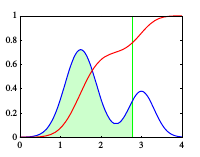

Fig.13 Schematic example of a probability density p(θ) shown by the blue curve, given in this example by a mixture of two Gaussians, along with its cumulative distribution function f (a), shown by the red curve. Note that the value of the blue curve at any point, such as that indicated by the vertical green line, corresponds to the slope of the red curve at the same point. Conversely, the value of the red curve at this point corresponds to the area under the blue curve indicated by the shaded green region. In the stochastic threshold model, the class label takes the value t = 1 if the value of a = wT φ exceeds a threshold, oth- erwise it takes the value t = 0. This is equivalent to an activation function given by the cumulative distribution function f (a).

## Probit Regression and Noisy Threshold Model

In this section, we explore **Probit Regression**, an alternative to logistic regression based on the cumulative distribution function (CDF) of a Gaussian. The activation function in probit regression is given by the probit function, which is closely related to the Gaussian error function.

## Probit Activation Function

Given a feature vector $\phi$, the model evaluates the linear combination:

$$
a = \mathbf{w}^T \phi
$$

The target value $t$ is then set based on a noisy threshold model:

$$
t = 
\begin{cases} 
1 & \text{if } a \geq \theta \\
0 & \text{otherwise}
\end{cases}
$$

where $\theta$ is drawn from a distribution $p(\theta)$. The activation function is the cumulative distribution function (CDF) of $p(\theta)$:

$$
f(a) = \int_{-\infty}^{a} p(\theta) d\theta
$$

For a standard Gaussian distribution, the probit function becomes:

$$
\Phi(a) = \int_{-\infty}^{a} \mathcal{N}(\theta | 0, 1) d\theta
$$

The probit function can also be expressed using the error function:

$$
\Phi(a) = \frac{1}{2} \left( 1 + \text{erf} \left( \frac{a}{\sqrt{2}} \right) \right)
$$

## Likelihood and Cross-Entropy Loss

In probit regression, the likelihood for a binary target $t \in \{0, 1\}$ given input $\phi$ is:

$$
p(t | \phi) = \Phi(a)^t (1 - \Phi(a))^{1 - t}
$$

The negative log-likelihood (cross-entropy loss) is then:

$$
E(\mathbf{w}) = - \sum_{n=1}^N \left[ t_n \log \Phi(a_n) + (1 - t_n) \log (1 - \Phi(a_n)) \right]
$$

where $a_n = \mathbf{w}^T \phi_n$.

## Sensitivity to Outliers

Probit regression behaves differently from logistic regression in the presence of outliers. While logistic regression's sigmoid function decays exponentially as $x \to \infty$:

$$
\text{logistic sigmoid} \sim e^{-x} \quad \text{as } x \to \infty
$$

the probit function decays faster:

$$
\text{probit} \sim e^{-x^2} \quad \text{as } x \to \infty
$$

This makes probit regression more sensitive to outliers.

## Mislabelled Data and Flipping Probability

To account for potential mislabelling, we introduce a flipping probability $\epsilon$, where $\epsilon$ is the probability that the target label $t$ has been flipped. The target distribution is then:

$$
p(t | x) = \epsilon + (1 - 2\epsilon) \sigma(x)
$$

where $\sigma(x)$ is the activation function (logistic or probit).

---

### Summary

Probit regression provides an alternative to logistic regression with similar applications but different sensitivity to outliers and mislabelling. It is useful in scenarios where Gaussian assumptions on the threshold noise are reasonable.


ValueError: too many values to unpack (expected 2)

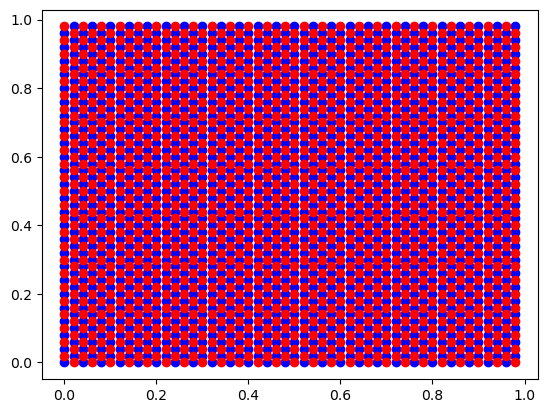

In [6]:
# Define necessary functions

# Matrix multiplication helper
def mat_mult(A, B):
    return [[sum(A[i][k] * B[k][j] for k in range(len(B))) for j in range(len(B[0]))] for i in range(len(A))]

# Transpose of a matrix
def transpose(A):
    return [[A[j][i] for j in range(len(A))] for i in range(len(A[0]))]

# Sigmoid approximation using the error function definition of Probit
def erf_approx(x, n_terms=10):
    # Approximate erf using Taylor series expansion
    term = x
    sum_ = x
    for n in range(1, n_terms):
        term *= -x**2 / n
        sum_ += term / (2 * n + 1)
    return 2 * sum_ / (3.14159**0.5)

def probit(x):
    return 0.5 * (1 + erf_approx(x / (2**0.5)))

# Generate synthetic data
def generate_data(n_samples):
    X = [[1, i / n_samples, j / n_samples] for i in range(n_samples) for j in range(n_samples)]
    T = [[1] if (i + j) % 2 == 0 else [0] for i in range(n_samples) for j in range(n_samples)]
    return X, T

# Compute gradients and perform iterative updates
def gradient_step(X, T, weights):
    n_samples = len(X)
    y_pred = [probit(sum(mat_mult([x], weights)[0])) for x in X]
    
    # Gradient
    grad = [[0] for _ in range(len(weights))]
    for x, t, y in zip(X, T, y_pred):
        for i in range(len(weights)):
            grad[i][0] += (y - t[0]) * x[i]
    return grad

def update_weights(weights, learning_rate, grad):
    # Weights Update
    for i in range(len(weights)):
        weights[i][0] -= learning_rate * grad[i][0]
    return weights

# Probit regression
def probit_regression(X, T, n_iterations=1000, learning_rate=0.1):
    weights = [[0] for _ in range(len(X[0]))]
    for _ in range(n_iterations):
        grad = gradient_step(X, T, weights)
        weights = update_weights(weights, learning_rate, grad)
    return weights

# Visualization
def plot_decision_boundary(X, T, weights):
    import matplotlib.pyplot as plt
    
    x_min, x_max = min(x[1] for x in X), max(x[1] for x in X)
    y_min, y_max = min(x[2] for x in X), max(x[2] for x in X)
    
    x_range = [x_min + i * (x_max - x_min) / 100 for i in range(100)]
    y_range = [y_min + i * (y_max - y_min) / 100 for i in range(100)]
    
    grid = [[1, x, y] for x in x_range for y in y_range]
    predictions = [1 if probit(sum(mat_mult([point], weights)[0])) > 0.5 else 0 for point in grid]
    
    plt.scatter([x[1] for x, t in zip(X, T) if t[0] == 1], [x[2] for x, t in zip(X, T) if t[0] == 1], color='blue', label='Class 1')
    plt.scatter([x[1] for x, t in zip(X, T) if t[0] == 0], [x[2] for x, t in zip(X, T) if t[0] == 0], color='red', label='Class 0')
    
    for (x, y), pred in zip(grid, predictions):
        plt.plot(x[1], x[2], 'go' if pred else 'mo', markersize=0.5, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Main function
if __name__ == "__main__":
    X, T = generate_data(50)
    weights = probit_regression(X, T, n_iterations=500, learning_rate=0.1)
    plot_decision_boundary(X, T, weights)


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


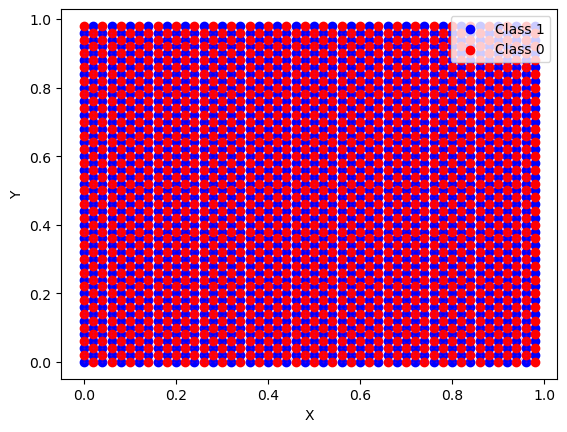

In [7]:
# Visualization
def plot_decision_boundary(X, T, weights):
    import matplotlib.pyplot as plt
    
    x_min, x_max = min(x[1] for x in X), max(x[1] for x in X)
    y_min, y_max = min(x[2] for x in X), max(x[2] for x in X)
    
    x_range = [x_min + i * (x_max - x_min) / 100 for i in range(100)]
    y_range = [y_min + i * (y_max - y_min) / 100 for i in range(100)]
    
    grid = [[1, x, y] for x in x_range for y in y_range]  # Creating grid points
    predictions = [1 if probit(sum(mat_mult([point], weights)[0])) > 0.5 else 0 for point in grid]
    
    # Scatter plot for class 1 and class 0
    plt.scatter([x[1] for x, t in zip(X, T) if t[0] == 1], [x[2] for x, t in zip(X, T) if t[0] == 1], color='blue', label='Class 1')
    plt.scatter([x[1] for x, t in zip(X, T) if t[0] == 0], [x[2] for x, t in zip(X, T) if t[0] == 0], color='red', label='Class 0')
    
    # Plotting decision boundary by plotting predictions
    for point, pred in zip(grid, predictions):
        plt.plot(point[1], point[2], 'go' if pred else 'mo', markersize=0.5, alpha=0.3)
    
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

# Main function
if __name__ == "__main__":
    X, T = generate_data(50)
    weights = probit_regression(X, T, n_iterations=500, learning_rate=0.1)
    plot_decision_boundary(X, T, weights)


###  Canonical Link Functions

For the linear regression model with a Gaussian noise distribution, the error function, corresponding to the negative log likelihood, is given by:

$$
E(w) = \sum_{n=1}^N \frac{1}{2} \left( y_n - t_n \right)^2
$$

If we take the derivative with respect to the parameter vector $w$ of the contribution to the error function from a data point $n$, this takes the form of the ‘error’ $ y_n - t_n $ times the feature vector $ \phi_n $, where $ y_n = w^T \phi_n $.

Similarly, for the combination of the logistic sigmoid activation function and the cross-entropy error function (Eq. 4.90), and for the softmax activation function with the multiclass cross-entropy error function (Eq. 4.108), we again obtain this same simple form. 

We now show that this is a general result of assuming a conditional distribution for the target variable from the exponential family, along with a corresponding choice for the activation function known as the **canonical link function**. 

We again make use of the restricted form of exponential family distributions:

$$
p(t | \eta, s) = h(t) \exp \left( \frac{t \eta}{s} - g(\eta) \right)
$$

Using the same line of argument as led to the derivation of the result (Eq. 2.226), we see that the conditional mean of $ t $, which we denote by $ y $, is given by:

$$
y = \frac{d}{d\eta} \left[ -s \ln g(\eta) \right]
$$

Thus, $ y $ and $ \eta $ are related, and we denote this relation through:

$$
\eta = \psi(y)
$$

Following Nelder and Wedderburn (1972), we define a **generalized linear model** to be one for which $ y $ is a nonlinear function of a linear combination of the input (or feature) variables, so that:

$$
y = f(w^T \phi)
$$

where $ f(\cdot) $ is known as the activation function in machine learning, and $ f^{-1}(\cdot) $ is known as the link function in statistics.

Now consider the log-likelihood function for this model, which, as a function of $ \eta $, is given by:

$$
\ln p(t | \eta, s) = \sum_{n=1}^N \ln p(t_n | \eta, s) = \sum_{n=1}^N \left[ \ln g(\eta_n) + \text{const} \right]
$$

where we are assuming that all observations share a common scale parameter (which corresponds to the noise variance for a Gaussian distribution, for instance), and so $ s $ is independent of $n$.

The derivative of the log-likelihood with respect to the model parameters $w$ is then given by:

$$
\nabla_w \ln p(t | \eta, s) = \sum_{n=1}^N \frac{1}{s} \left[ t_n - y_n \right] \psi'(y_n) f'(a_n) \phi_n
$$

where $ a_n = w^T \phi_n $, and we have used $ y_n = f(a_n) $ together with the result for $ E[t | \eta] $.

We now see that there is considerable simplification if we choose a particular form for the link function $ f^{-1}(y) $ given by:

$$
f^{-1}(y) = \psi(y)
$$

which gives $ f(\psi(y)) = y $ and hence $ f'(\psi(y)) \psi'(y) = 1 $. Also, because $ a = f^{-1}(y) $, we have $ a = \psi(y) $, and hence $ f'(a) \psi'(y) = 1 $.

In this case, the gradient of the error function reduces to:

$$
\nabla \ln E(w) = \frac{1}{s} \sum_{n=1}^N \left[ y_n - t_n \right] \phi_n
$$

For the Gaussian, $ s = \beta^{-1} $, whereas for the logistic model, $ s = 1 $.


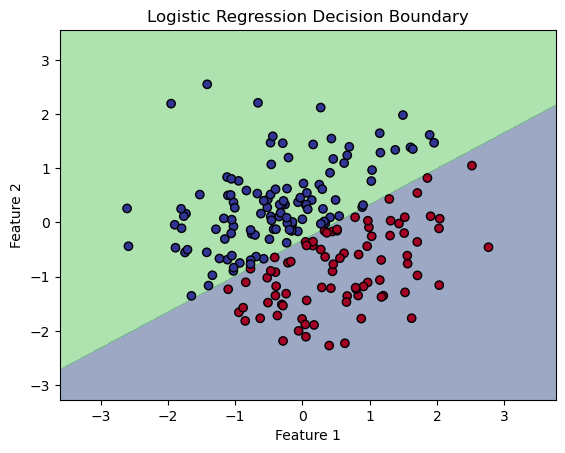

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data (for logistic regression)
def generate_data(N, dim=2):
    # Random features X with N samples and 'dim' features (with a bias term)
    X = np.random.randn(N, dim)
    X = np.hstack([np.ones((N, 1)), X])  # Add bias term (1s column)
    # Target variable t from logistic function
    true_weights = np.array([1, -2, 3])  # True weights
    linear_combination = np.dot(X, true_weights)
    # Sigmoid to generate binary targets
    T = 1 / (1 + np.exp(-linear_combination))
    T = (T > 0.5).astype(int)  # Convert to binary (0 or 1)
    return X, T

# Step 2: Define activation function (logistic sigmoid function)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Step 3: Log-Likelihood function for logistic regression
def log_likelihood(X, T, weights):
    z = np.dot(X, weights)
    return np.sum(T * np.log(sigmoid(z)) + (1 - T) * np.log(1 - sigmoid(z)))

# Step 4: Gradient of the log-likelihood (for logistic regression)
def gradient_log_likelihood(X, T, weights):
    z = np.dot(X, weights)
    predictions = sigmoid(z)
    return np.dot(X.T, (predictions - T))  # Gradient of the log-likelihood

# Step 5: Perform gradient descent to optimize weights
def gradient_descent(X, T, learning_rate=0.1, n_iterations=1000):
    N, d = X.shape
    weights = np.zeros(d)  # Initialize weights
    for _ in range(n_iterations):
        grad = gradient_log_likelihood(X, T, weights)
        weights -= learning_rate * grad  # Update weights
    return weights

# Step 6: Plot the decision boundary
def plot_decision_boundary(X, T, weights):
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = sigmoid(np.dot(np.c_[np.ones(xx.ravel().shape), xx.ravel(), yy.ravel()], weights))
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.5)
    plt.scatter(X[:, 1], X[:, 2], c=T, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")
    plt.show()

# Step 7: Running the model
X, T = generate_data(200)  # Generate synthetic data with 200 samples
weights = gradient_descent(X, T, learning_rate=0.1, n_iterations=1000)  # Perform gradient descent
plot_decision_boundary(X, T, weights)  # Plot the decision boundary


TypeError: Length of x (6319) must match number of columns in z (71)

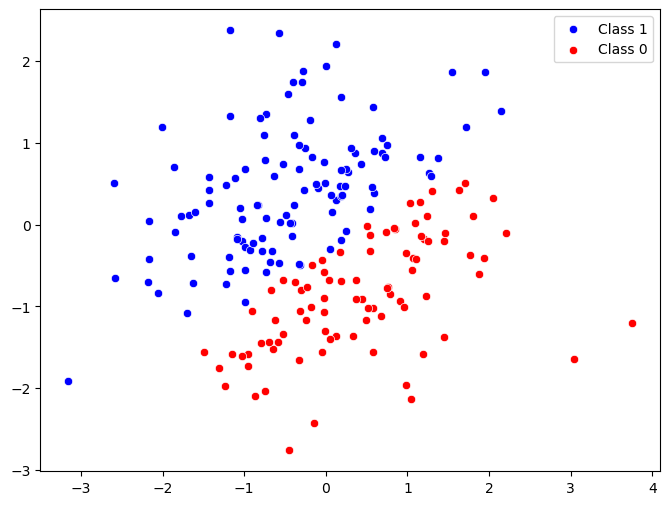

In [10]:
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
def generate_data(N, dim=2):
    X = []
    T = []
    # Random features X (N samples, dim features)
    for i in range(N):
        X.append([1] + [random.gauss(0, 1) for _ in range(dim)])  # Add bias term (1s column)
    # True weights for linear combination
    true_weights = [1, -2, 3]
    # Target variable t using logistic function
    for x in X:
        linear_comb = sum([x[j] * true_weights[j] for j in range(len(true_weights))])
        t = 1 / (1 + math.exp(-linear_comb))
        T.append(1 if t > 0.5 else 0)  # Convert to binary target (0 or 1)
    return X, T

# Step 2: Define activation function (logistic sigmoid)
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Step 3: Log-Likelihood function for logistic regression
def log_likelihood(X, T, weights):
    log_likelihood = 0
    for i in range(len(T)):
        z = sum([X[i][j] * weights[j] for j in range(len(weights))])
        log_likelihood += T[i] * math.log(sigmoid(z)) + (1 - T[i]) * math.log(1 - sigmoid(z))
    return log_likelihood

# Step 4: Gradient of the log-likelihood (for logistic regression)
def gradient_log_likelihood(X, T, weights):
    grad = [0] * len(weights)
    for i in range(len(T)):
        z = sum([X[i][j] * weights[j] for j in range(len(weights))])
        prediction = sigmoid(z)
        for j in range(len(weights)):
            grad[j] += (prediction - T[i]) * X[i][j]
    return grad

# Step 5: Perform gradient descent to optimize weights
def gradient_descent(X, T, learning_rate=0.1, n_iterations=1000):
    N, d = len(X), len(X[0])
    weights = [0] * d  # Initialize weights
    for _ in range(n_iterations):
        grad = gradient_log_likelihood(X, T, weights)
        for j in range(len(weights)):
            weights[j] -= learning_rate * grad[j]  # Update weights
    return weights

# Step 6: Plot the decision boundary
def plot_decision_boundary(X, T, weights):
    # Create a grid of points to plot the decision boundary
    x_min, x_max = min([x[1] for x in X]) - 1, max([x[1] for x in X]) + 1
    y_min, y_max = min([x[2] for x in X]) - 1, max([x[2] for x in X]) + 1
    xx, yy = [], []
    step = 0.1  # Resolution of the grid
    for i in range(int((x_max - x_min) / step)):
        for j in range(int((y_max - y_min) / step)):
            xx.append(x_min + i * step)
            yy.append(y_min + j * step)

    zz = []
    for i in range(len(xx)):
        # Creating feature vector for each grid point
        grid_point = [1, xx[i], yy[i]]  # Adding bias term and the current grid point (x, y)
        z = sum([grid_point[j] * weights[j] for j in range(len(weights))])  # Linear combination
        zz.append(sigmoid(z))  # Apply sigmoid to get probability

    # Create scatter plot of points and plot the decision boundary
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=[x[1] for x, t in zip(X, T) if t == 1], y=[x[2] for x, t in zip(X, T) if t == 1], color='blue', label='Class 1')
    sns.scatterplot(x=[x[1] for x, t in zip(X, T) if t == 0], y=[x[2] for x, t in zip(X, T) if t == 0], color='red', label='Class 0')
    
    # Reshaping zz into the grid shape for contour plotting
    zz_grid = [zz[i:i + int((y_max - y_min) / 0.1)] for i in range(0, len(zz), int((y_max - y_min) / 0.1))]
    plt.contourf(xx, yy, zz_grid, levels=[0, 0.5, 1], alpha=0.5)
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression Decision Boundary')
    plt.legend()
    plt.show()

# Step 7: Running the model
X, T = generate_data(200)  # Generate synthetic data with 200 samples
weights = gradient_descent(X, T, learning_rate=0.1, n_iterations=1000)  # Perform gradient descent
plot_decision_boundary(X, T, weights)  # Plot the decision boundary


###  The Laplace Approximation


In Section 4.5 we shall discuss the Bayesian treatment of logistic regression. As we shall see, this is more complex than the Bayesian treatment of linear regression models, discussed in Sections 3.3 and 3.5. In particular, we cannot integrate exactly over the parameter vector $ \mathbf{w} $ since the posterior distribution is no longer Gaussian. It is therefore necessary to introduce some form of approximation. Later in the book, we shall consider a range of techniques based on analytical approximations and numerical sampling. Here we introduce a simple, but widely used, framework called the **Laplace approximation**, that aims to find a Gaussian approximation to a probability density defined over a set of continuous variables.

Consider first the case of a single continuous variable $ z $, and suppose the distribution $ p(z) $ is defined by:

$$
p(z) = \frac{f(z)}{Z}
$$

where $ Z = \int f(z) \, dz $ is the normalization coefficient. We shall suppose that the value of $ Z $ is unknown.

In the Laplace method, the goal is to find a Gaussian approximation $ q(z) $, which is centered on a mode of the distribution $ p(z) $. The first step is to find a mode of $ p(z) $, in other words, a point $ z_0 $ such that:

$$
\frac{d}{dz} f(z) \bigg|_{z=z_0} = 0 \quad \text{or equivalently} \quad \frac{d}{dz} \ln f(z) \bigg|_{z=z_0} = 0
$$

A Gaussian distribution has the property that its logarithm is a quadratic function of the variables. We therefore consider a Taylor expansion of $ \ln f(z) $ centered on the mode $ z_0 $, so that:

$$
\ln f(z) \approx \ln f(z_0) - \frac{A}{2}(z - z_0)^2
$$

where

$$
A = - \left. \frac{d^2}{dz^2} \ln f(z) \right|_{z=z_0}
$$

Note that the first-order term in the Taylor expansion does not appear since $ z_0 $ is a local maximum of the distribution. Taking the exponential of both sides, we obtain:

$$
f(z) \approx f(z_0) \exp\left( -\frac{A}{2}(z - z_0)^2 \right)
$$

We can then obtain a normalized distribution $ q(z) $ by making use of the standard result for the normalization of a Gaussian, so that:

$$
q(z) = \frac{1}{\sqrt{2 \pi / A}} \exp\left( -\frac{A}{2}(z - z_0)^2 \right)
$$

The Laplace approximation is illustrated in Fig.14. Note that the Gaussian approximation will only be well-defined if its precision $ A > 0 $, in other words, the stationary point $ z_0 $ must be a local maximum, so that the second derivative of $ f(z) $ at the point $ z_0 $ is negative.

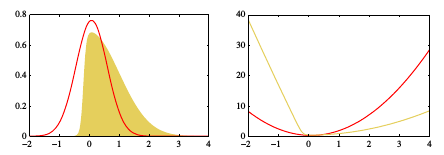

Fig.14 Illustration of the Laplace approximation applied to the distribution p(z) ∝ exp(−z 2 /2)σ(20z + 4) where σ(z) is the logistic sigmoid function deﬁned by σ(z) = (1 + e−z )−1 . The left plot shows the normalized distribution p(z) in yellow, together with the Laplace approximation centred on the mode z0 of p(z) in red. The right plot shows the negative logarithms of the corresponding curves.


Mode (MAP estimate) of w: [ 0.9771147  -0.61155996]
Posterior covariance matrix: [[ 0.0855116  -0.01092748]
 [-0.01092748  0.05512519]]


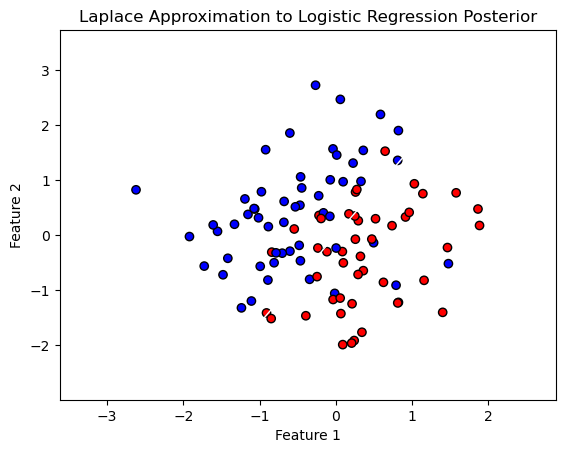

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit  # Logistic sigmoid function

# Define logistic regression model
def logistic_regression(X, w):
    """ Logistic regression model with sigmoid function """
    return expit(np.dot(X, w))  # Sigmoid activation

# Log-Likelihood function for logistic regression
def log_likelihood(X, t, w):
    """ Compute log-likelihood for logistic regression """
    y = logistic_regression(X, w)
    return np.sum(t * np.log(y) + (1 - t) * np.log(1 - y))

# Gradient of log-likelihood
def gradient_log_likelihood(X, t, w):
    """ Compute gradient of log-likelihood with respect to weights """
    y = logistic_regression(X, w)
    return np.dot(X.T, (y - t))

# Hessian of log-likelihood (second derivative)
def hessian_log_likelihood(X, t, w):
    """ Compute the Hessian (second derivative) of the log-likelihood """
    y = logistic_regression(X, w)
    S = np.diag(y * (1 - y))  # Diagonal matrix of the variance of the logistic sigmoid
    return np.dot(np.dot(X.T, S), X)

# Laplace Approximation
def laplace_approximation(X, t):
    """ Compute Laplace approximation of posterior for logistic regression """
    
    # Initial guess for w (e.g., all zeros or a random initialization)
    w_init = np.zeros(X.shape[1])
    
    # Optimization: Use Newton's method or other optimization method to find mode w_0
    # Here, we'll use a simple gradient ascent with Newton's method for the Hessian inverse
    w_0 = w_init
    learning_rate = 0.01
    n_iterations = 100
    
    for _ in range(n_iterations):
        gradient = gradient_log_likelihood(X, t, w_0)
        hessian = hessian_log_likelihood(X, t, w_0)
        # Update rule: Newton's method (w_new = w_old - inv(Hessian) * Gradient)
        w_0 -= learning_rate * np.linalg.inv(hessian).dot(gradient)
    
    # Hessian at the mode (w_0) is used for the Laplace approximation
    hessian_at_mode = hessian_log_likelihood(X, t, w_0)
    posterior_covariance = np.linalg.inv(hessian_at_mode)  # Inverse of the Hessian gives covariance
    
    return w_0, posterior_covariance

# Generate synthetic data (for binary classification)
np.random.seed(42)
N = 100  # Number of samples
X = np.random.randn(N, 2)  # 2-dimensional features
true_w = np.array([2, -1])  # True weights
t = np.random.binomial(1, logistic_regression(X, true_w))  # Binary targets

# Apply Laplace Approximation
w_0, posterior_covariance = laplace_approximation(X, t)

print("Mode (MAP estimate) of w:", w_0)
print("Posterior covariance matrix:", posterior_covariance)

# Visualize the decision boundary (Laplace approximation)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Get predictions from the Laplace approximation
predictions = logistic_regression(grid_points, w_0).reshape(xx.shape)

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.bwr, marker='o', edgecolors='k')

# Plot decision boundary (Laplace approximation)
plt.contour(xx, yy, predictions, levels=[0.5], cmap='Greys', linewidths=1)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Laplace Approximation to Logistic Regression Posterior')
plt.show()


###  Model Comparison and BIC

As well as approximating the distribution $ p(z) $, we can also obtain an approximation to the normalization constant $ Z $. Using the approximation (4.133), we have:

$$
Z = \int f(z) \, dz \approx f(z_0) \int \exp \left( -\frac{(z - z_0)^2}{2A} \right) \, dz
$$

where $ A = - \left. \frac{d^2}{dz^2} \ln f(z) \right|_{z=z_0} $.

Since the integrand is Gaussian, we can make use of the standard result for a normalized Gaussian distribution:

$$
\int \exp \left( -\frac{(z - z_0)^2}{2A} \right) \, dz = \sqrt{2\pi A}
$$

Thus, the normalization constant \( Z \) is approximated as:

$$
Z \approx f(z_0) \cdot \sqrt{2\pi A}
$$

This result can be used to obtain an approximation to the **model evidence**, which plays a central role in **Bayesian model comparison**.

Consider a data set $ D $ and a set of models $ \{M_i \} $ with parameters $ \{\theta_i\} $. For each model, we define a likelihood function $ p(D | \theta_i, M_i) $. If we introduce a prior $ p(\theta_i | M_i) $ over the parameters, then we are interested in computing the model evidence $ p(D | M_i) $ for the various models. From Bayes' theorem, the model evidence is given by:

$$
p(D) = \int p(D | \theta) p(\theta) \, d\theta
$$

Identifying $ f(\theta) = p(D | \theta) p(\theta) $ and $ Z = p(D) $, and applying the result (4.135), we obtain the following approximation for the log model evidence:

$$
\ln p(D) \approx \ln p(D | \theta_{\text{MAP}}) + \ln p(\theta_{\text{MAP}}) + \ln(2\pi) - \frac{1}{2} \ln |A|
$$

where $ \theta_{\text{MAP}} $ is the value of $ \theta $ at the mode of the posterior distribution, and $ A $ is the Hessian matrix of second derivatives of the negative log-posterior:

$$
A = - \nabla \nabla \ln p(\theta_{\text{MAP}} | D)
$$

The first term on the right-hand side of this equation represents the log-likelihood evaluated using the optimized parameters. The remaining three terms comprise the **"Occam factor"**, which penalizes model complexity.

If we assume that the Gaussian prior distribution over parameters is broad and that the Hessian has full rank, then we can approximate the model evidence as:

$$
\ln p(D) \approx \ln p(D | \theta_{\text{MAP}}) - \frac{M}{2} \ln N
$$

where $ N $ is the number of data points, $ M $ is the number of parameters in $ \theta $, and we have omitted additive constants. This is known as the **Bayesian Information Criterion (BIC)** or the **Schwarz criterion** (Schwarz, 1978).

Compared to the Akaike Information Criterion (AIC), which is given by:

$$
\text{AIC} = -2 \ln L + 2M
$$

the BIC penalizes model complexity more heavily. Both AIC and BIC are easy to evaluate, but they can give misleading results. In particular, the assumption that the Hessian matrix has full rank is often not valid since many parameters may not be "well-determined."

We can use the result (4.137) to obtain a more accurate estimate of the model evidence, starting from the Laplace approximation, as we illustrate in the context of neural networks in Section 5.7.


In [13]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Generate synthetic classification data
X, y = make_classification(n_samples=100, n_features=5, n_informative=3, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic regression log-likelihood
def log_likelihood(w, X, y):
    z = X.dot(w)
    return np.sum(y * np.log(sigmoid(z)) + (1 - y) * np.log(1 - sigmoid(z)))

# Gradient of the log-likelihood
def gradient(w, X, y):
    z = X.dot(w)
    return X.T.dot(sigmoid(z) - y)

# Hessian (second derivative of the negative log-likelihood)
def hessian(w, X, y):
    z = X.dot(w)
    p = sigmoid(z)
    diag = p * (1 - p)
    return X.T.dot(diag[:, None] * X)

# Fit logistic regression using sklearn
log_reg = LogisticRegression(solver='lbfgs', fit_intercept=False)
log_reg.fit(X_train, y_train)

# Get the MAP estimate of the parameters
w_map = log_reg.coef_.flatten()

# Compute the Hessian at the MAP point
Hessian = hessian(w_map, X_train, y_train)

# Compute the determinant of the Hessian matrix
Hessian_det = np.linalg.det(Hessian)

# Compute the Laplace Approximation to the model evidence
log_p_d = log_likelihood(w_map, X_train, y_train) - 0.5 * np.log(Hessian_det)

# Model comparison using BIC (Bayesian Information Criterion)
N = len(y_train)  # Number of data points
M = len(w_map)    # Number of parameters

bic = -2 * log_p_d + M * np.log(N)

print("Laplace Approximation to the log model evidence: ", log_p_d)
print("BIC: ", bic)


Laplace Approximation to the log model evidence:  inf
BIC:  -inf


/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


Laplace Approximation to the log model evidence:  -12.504587088758456
BIC:  38.824684735481185


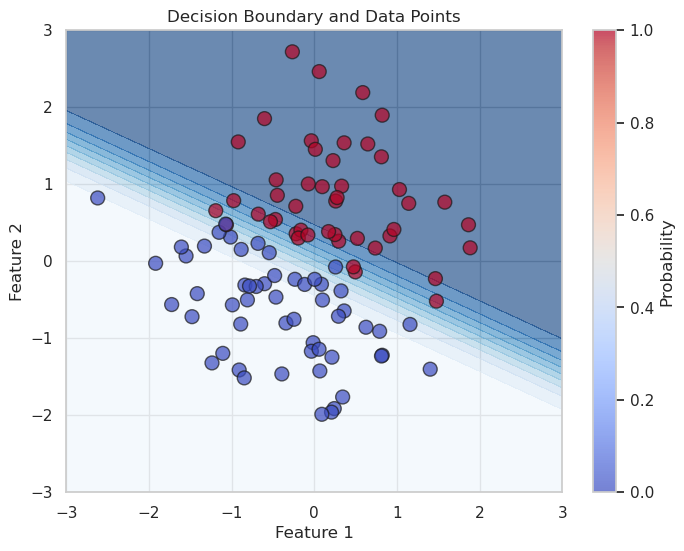

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generating synthetic classification data manually
np.random.seed(42)

def generate_data(n_samples=100, n_features=2):
    X = np.random.randn(n_samples, n_features)
    w_true = np.array([1, 2])  # True weights (only two features now)
    z = X.dot(w_true) + np.random.randn(n_samples) * 0.1  # Linear combination + noise
    y = (sigmoid(z) > 0.5).astype(int)  # Apply sigmoid and classify
    return X, y

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def log_likelihood(w, X, y):
    z = X.dot(w)
    return np.sum(y * np.log(sigmoid(z)) + (1 - y) * np.log(1 - sigmoid(z)))

def gradient(w, X, y):
    z = X.dot(w)
    return X.T.dot(sigmoid(z) - y)

def hessian(w, X, y):
    z = X.dot(w)
    p = sigmoid(z)
    diag = p * (1 - p)
    return X.T.dot(diag[:, None] * X)

# Generate synthetic data
X, y = generate_data()

# Add a column of ones to X for the intercept term (for simplicity, no need for sklearn here)
X_ = np.c_[np.ones(X.shape[0]), X]

# Initial guess for the weights (random)
w_init = np.zeros(X_.shape[1])

# Manually applying gradient descent for logistic regression
def gradient_descent(X, y, w_init, learning_rate=0.01, n_iter=100):
    w = w_init
    for _ in range(n_iter):
        grad = gradient(w, X, y)
        w -= learning_rate * grad  # Update weights
    return w

# Find the MAP estimate (using gradient descent)
w_map = gradient_descent(X_, y, w_init)

# Compute the Hessian matrix at the MAP point
Hessian = hessian(w_map, X_, y)

# Compute the determinant of the Hessian matrix
Hessian_det = np.linalg.det(Hessian)

# Compute the Laplace Approximation to the model evidence
log_p_d = log_likelihood(w_map, X_, y) - 0.5 * np.log(Hessian_det)

# Model comparison using BIC (Bayesian Information Criterion)
N = len(y)  # Number of data points
M = len(w_map)  # Number of parameters

bic = -2 * log_p_d + M * np.log(N)

# Output the results
print("Laplace Approximation to the log model evidence: ", log_p_d)
print("BIC: ", bic)

# Visualization (using seaborn)
# Plotting decision boundary and data points (for illustration)
sns.set(style="whitegrid")

# Create a grid for the decision boundary plot
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_ = np.c_[np.ones(grid.shape[0]), grid]  # Add intercept term

# Get predictions from the model
z_grid = grid_.dot(w_map)  # Make sure this matches the dimensionality of grid_
probs = sigmoid(z_grid).reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs, levels=np.linspace(0, 1, 11), cmap="Blues", alpha=0.6)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolors='k', s=100, alpha=0.7)
plt.title("Decision Boundary and Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Probability")
plt.show()
